# Построение ML-продукта для предсказания следующего заказа пользователя

- **Описание**
<br>Сервисы доставки еды уже давно перестали быть просто курьерами, которые привозят заказ. Индустрия e-grocery стремительно идет к аккумулированию и использованию больших данных, чтобы знать о своих пользователях больше и предоставлять более качественные и персонализированные услуги. Одним из шагов к такой персонализации может быть разработка модели, которая понимает привычки и нужды пользователя, и, к примеру, может угадать, что и когда пользователь захочет заказать в следующий раз.

Такая модель, будучи разработанной, может принести значительную ценность для клиента - сэкономить время при сборке корзины, помочь ничего не забыть в заказе, убрать необходимость планировать закупки и следить за заканчивающимися запасами продуктов.

В данном соревновании участникам предлагается решить задачу предсказания следующего заказа пользователя (безотносительно конкретного момента времени, когда этот заказ произойдет). Заказ пользователя состоит из списка уникальных категорий товаров, вне зависимости от того, сколько продуктов каждой категории он взял.

- **Метрика Заказчика: F1-score**

- **Описание данных**
<br>В качестве тренировочных данных представляется датасет с историей заказов 20000 пользователей вплоть до даты отсечки, которая разделяет тренировочные и тестовые данные по времени.

train.csv:
- user_id - уникальный id пользователя
- order_completed_at - дата заказа
- cart - список уникальных категорий (category_id), из которых состоял заказ
<br>В качестве прогноза необходимо для каждой пары пользователь-категория из примера сабмита вернуть 1, если категория будет присутствовать в следующем заказе пользователя, или 0 в ином случае. Список категорий для каждого пользователя примере сабмита - это все категории, которые он когда-либо заказывал.

sample_submission.csv:
Пример сабмита. В тест входят не все пользователи из тренировочных данных, так как некоторые из них так ничего и не заказали после даты отсечки.

- id - идентификатор строки - состоит из user_id и category_id, разделенных точкой с запятой: f'{user_id};{category_id}'. Из-за особенностей проверяющей системы Kaggle InClass, использовать колонки user_id, category_id в качестве индекса отдельно невозможно
- target - 1 или 0 - будет ли данная категория присутствовать в следующем заказе пользователя

<br>План
- знакомство с данными
- чистка, первичная обработка
- исследовательский анализ данных
- разделение на выборки
- обучение моделей
- выбор лучшей модели
- тестирование моделей (тестовая выборка - 1 год)
- построение прогноза (период выбран годовой, с удалением повторных входов id)

## Настройка рабочей среды

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# from prophet import Prophet
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from kaggle_secrets import UserSecretsClient
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (cross_validate,
                                     StratifiedKFold,
                                     train_test_split)
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler, FunctionTransformer

Установка констант

In [2]:
RANDOM_STATE=42
PRED = 30  # PRED = 120

## Загрузка и первичный EDA

In [3]:
try:
    df = pd.read_csv(UserSecretsClient().get_secret("train_path"), parse_dates=['order_completed_at'])
    sample_sub = pd.read_csv(UserSecretsClient().get_secret("sample_submission_path"))
    print('загружено из каталога Kaggle')
except:
    df = pd.read_csv('data/train.csv')
    sample_sub = pd.read_csv('data/sample_submission.csv')
    print('загружено из каталога "data"')

загружено из каталога Kaggle


### Импорт выходных и праздничных дней
<br>Загружено с сайта [xmlcalendar](https://xmlcalendar.ru/)

In [4]:
years = [2015, 2016, 2017, 2018, 2019, 2020]
holidays_dict = {}

for year in years:
    url = f"https://xmlcalendar.ru/data/ru/{year}/calendar.csv"
    holidays_dict[f'{year}'] = pd.read_csv(url)
print('данные успешно загружены')

данные успешно загружены


In [5]:
def date_preparation(data, year):
    '''
    - на вход принимает датасет с праздниками и год этого датасета
    - возвращает обработанный датасет
    '''
    data = data.reset_index(drop=True).T[:13]
    data = data.set_axis(data.iloc[0], axis=1)[1:]
    data.insert(0, 'month', range(1, len(data) + 1))
    data.insert(0, 'year', year)
    data = data.replace(['\+', '\*'], '', regex=True)
    data[year] = data[year].str.split(',')
    data = data.explode(year)
    data = data.rename(columns={year: 'day'})
    data['date'] = pd.to_datetime(data[['year', 'month', 'day']])
    
    return data

In [6]:
holidays = pd.DataFrame()

for year, year_str in zip(years, holidays_dict.keys()):
    holidays_year = date_preparation(holidays_dict[year_str], year)
    holidays = pd.concat([holidays, holidays_year], ignore_index=True)

holidays.sample(5)

Год/Месяц,year,month,day,date
341,2017,10,21,2017-10-21
228,2016,11,6,2016-11-06
26,2015,3,7,2015-03-07
220,2016,10,16,2016-10-16
559,2019,7,6,2019-07-06


### Исследование данных

In [7]:
df.info()
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3123064 entries, 0 to 3123063
Data columns (total 3 columns):
 #   Column              Dtype         
---  ------              -----         
 0   user_id             int64         
 1   order_completed_at  datetime64[ns]
 2   cart                int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 71.5 MB


,user_id,order_completed_at,cart
68474,1162,2019-05-14 11:59:28,23
1543835,10571,2020-05-17 14:57:49,95
733097,2971,2020-01-22 10:49:59,64
1147461,11525,2020-04-07 04:35:21,410
2772295,6208,2020-08-11 09:01:33,244


In [8]:
print(f"количество полных дубликатов строк: {df.duplicated().sum()}")

количество полных дубликатов строк: 0


In [9]:
print(f"начальная дата наблюдений: {df['order_completed_at'].min()}")
print(f"конечная дата наблюдений: {df['order_completed_at'].max()}")

начальная дата наблюдений: 2015-03-22 09:25:46
конечная дата наблюдений: 2020-09-03 23:45:45


In [10]:
sample_sub.info()
display(sample_sub.head())
print(f"количество уникальных сочетаний id: {sample_sub['id'].nunique()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790449 entries, 0 to 790448
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      790449 non-null  object
 1   target  790449 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 12.1+ MB


,id,target
0,0;133,0
1,0;5,1
2,0;10,0
3,0;396,1
4,0;14,0


количество уникальных сочетаний id: 790449


In [11]:
df[(df['user_id'] == 2) & (df['cart'] == 57)]

,user_id,order_completed_at,cart
14,2,2015-03-22 09:25:46,57
97,2,2016-05-27 19:21:46,57
10697,2,2018-01-12 23:36:19,57
222784,2,2019-10-03 17:37:23,57
246982,2,2019-10-11 09:05:20,57
307939,2,2019-10-25 21:05:56,57
345177,2,2019-11-02 22:00:26,57
382037,2,2019-11-09 20:45:19,57
404912,2,2019-11-13 19:05:45,57
599000,2,2019-12-22 14:57:39,57


### Выводы и наблюдения
- полных дубликатов строк не обнаружено
- данные предоставлены за пять лет: с 22.03.2015 до 03.09.2020
- в датафрейме `sample_sub` представлены `id` пользователей с `id` товаров и целевой признак
- количество уникальных сочетаний id - 790449

## Предобработка данных

Кумулятивная сумма покупок по клиенту за 120 дней

In [12]:
# df['client_cum_sum_120'] = 0
# prev_client_id = None
# prev_purchase_date = None
# client_cum_sum_120 = 0

# for index, row in df.iterrows():
#     if (prev_client_id == row['user_id'] 
#         and (row['order_completed_at'] - prev_purchase_date).days <= 120):
#         client_cum_sum_120 += 1
#     else:
#         client_cum_sum_120 = 1

#     df.at[index, 'client_cum_sum_120'] = client_cum_sum_120

#     prev_client_id = row['user_id']
#     prev_purchase_date = row['order_completed_at']
# df.to_csv('cumulative_sum.csv', index=False)
# print('сохранён датафрейм с признаком накопительной суммы покупок')
# df.sample(5)

In [13]:
# try:
#     df = pd.read_csv('data/cumulative_sum.csv', parse_dates=['order_completed_at'])
#     print('загружено из каталога "data"')
# except:
#     df = pd.read_csv('/kaggle/input/preparing-data/cumulative_sum.csv', parse_dates=['order_completed_at'])
#     print('загружено из каталога Kaggle')
# finally:
#     print(df.sample(5))

In [14]:
# print(f"""количество уникальных сочетаний id за последние 120 дней:
# {df_w[df_w['order_completed_at'] >= 
# (df_w['order_completed_at'].max() - pd.DateOffset(days=PRED))]['id'].nunique()}""")

Создание целевого признака

In [15]:
# df_w['target'] = 0

# last_occurrence = {}

# for index, row in df_w.iterrows():
#     id_value = row['id']
#     if id_value in last_occurrence:
#         df_w.at[last_occurrence[id_value], 'target'] = 1
#     last_occurrence[id_value] = index
    
# df_w.to_csv('target_data.csv', index=False)
# print('target создан, датафрейм сохранён')

Загрузка датафрейма с таргетом

In [16]:
# try:
#     df_w = pd.read_csv('data/target_data.csv', parse_dates=['order_completed_at'])
#     print('загружено из каталога "data"')
# except:
#     df_w = pd.read_csv('/kaggle/input/preparing-data/target_data.csv', parse_dates=['order_completed_at'])
#     print('загружено из каталога Kaggle')
# finally:
#     print(df_w.shape)

Проверка корректности созданного target

In [17]:
# df_w[df_w['id'] == '2;57']

Добавление признака `is_holiday`

In [18]:
df['date'] = df['order_completed_at'].apply(lambda x: x.strftime('%Y-%m-%d'))
df['date'] = pd.to_datetime(df['date'])
# df_w['target'] = df_w['target'].astype('int8')
df['is_holiday'] = df['date'].isin(holidays['date']).astype('int8')
df.drop('date', axis=1, inplace=True)
df.head()

,user_id,order_completed_at,cart,is_holiday
0,2,2015-03-22 09:25:46,399,1
1,2,2015-03-22 09:25:46,14,1
2,2,2015-03-22 09:25:46,198,1
3,2,2015-03-22 09:25:46,88,1
4,2,2015-03-22 09:25:46,157,1


Кумулятивная сумма за 120 дней по сочетанию `user_id` + `cart`

In [19]:
# нет смысла
# id_cum_sum_120
# 1    3123037
# 2         27
# Name: count, dtype: int64

# df_w['id_cum_sum_120'] = 0
# prev_id = None
# prev_date = None
# id_cum_sum_120 = 0

# for index, row in df_w.iterrows():
#     if (prev_id == row['id'] 
#         and (row['order_completed_at'] - prev_date).days <= 120):
#         id_cum_sum_120 += 1
#     else:
#         id_cum_sum_120 = 1

#     df_w.at[index, 'id_cum_sum_120'] = id_cum_sum_120

#     prev_id = row['id']
#     prev_date = row['order_completed_at']
# df_w.sample(5)

Соотношение классов целевого признака

In [20]:
# sizes = [df_w['target'].value_counts()[1], df_w['target'].value_counts()[0]]
# fig1, ax1 = plt.subplots()
# ax1.pie(sizes, labels=['True', 'False'], autopct='%1.0f%%')
# plt.title('Соотношение классов целевого признака', size=12)
# plt.show()

### Выводы и наблюдения
- создан признак `is_holiday`

Отменённые преобразования:
- добавлен признак `client_cum_sum_120` кумулятивной суммы 
  <br>активностей клиента в течение 120-ти дней
- объединены `user_id` клиента и `cart` категории товаров в один признак `id`
- создан целевой признак `target`
- добавлен признак `id_cum_sum_120` кумулятивной суммы 
  <br>активностей сочетания `client_id` + `cart` в течение 120-ти дней
- изучен баланс классов целевого признака:
  - наблюдается значительный дисбаланс в сторону положительного класса

# Статический подход к решению задачи

In [21]:
df.head()

,user_id,order_completed_at,cart,is_holiday
0,2,2015-03-22 09:25:46,399,1
1,2,2015-03-22 09:25:46,14,1
2,2,2015-03-22 09:25:46,198,1
3,2,2015-03-22 09:25:46,88,1
4,2,2015-03-22 09:25:46,157,1


## Генерация дополнительных признаков

Разница в днях между покупками клиента

In [22]:
# Сортировка датафрейма по столбцам client_id и order_completed_at
df.sort_values(by=['user_id', 'order_completed_at'], inplace=True)

# Группировка по client_id и вычисление разницы в днях между покупками
df['days_between_client_purchases'] = df.groupby('user_id')['order_completed_at'].diff().dt.days
df['days_between_client_purchases'] = df['days_between_client_purchases'].fillna(0).astype('int64')
df.head()

,user_id,order_completed_at,cart,is_holiday,days_between_client_purchases
2422913,0,2020-07-19 09:59:17,20,1,0
2422914,0,2020-07-19 09:59:17,82,1,0
2422915,0,2020-07-19 09:59:17,441,1,0
2422916,0,2020-07-19 09:59:17,57,1,0
2422917,0,2020-07-19 09:59:17,14,1,0


Разница в днях между покупками определённого товара

In [23]:
# Сортировка датафрейма по столбцам cart_id и order_completed_at
df.sort_values(by=['cart', 'order_completed_at'], inplace=True)

# Группировка по cart_id и вычисление разницы в днях между покупками
df['days_between_cart_purchases'] = df.groupby('cart')['order_completed_at'].diff().dt.days
df['days_between_cart_purchases'] = df['days_between_cart_purchases'].fillna(0).astype('int64')
df.head()

,user_id,order_completed_at,cart,is_holiday,days_between_client_purchases,days_between_cart_purchases
255,24,2016-08-13 02:54:47,0,1,0,0
262,24,2016-08-21 18:52:51,0,1,0,8
292,21,2016-08-23 23:29:05,0,0,0,2
312,29,2016-09-05 11:10:35,0,0,0,12
388,34,2016-09-28 22:26:35,0,0,0,23


Объединение `user_id` и `cart` в признак `id`

In [24]:
df['id'] = df['user_id'].astype(str) + ';' + df['cart'].astype(str)
df.drop(['user_id', 'cart'], axis=1, inplace=True)
df.head()

,order_completed_at,is_holiday,days_between_client_purchases,days_between_cart_purchases,id
255,2016-08-13 02:54:47,1,0,0,24;0
262,2016-08-21 18:52:51,1,0,8,24;0
292,2016-08-23 23:29:05,0,0,2,21;0
312,2016-09-05 11:10:35,0,0,12,29;0
388,2016-09-28 22:26:35,0,0,23,34;0


Удаление даты, группировка по `id` с агрегациями

In [25]:
df = df.drop('order_completed_at', axis=1).groupby('id').agg({
    'is_holiday': 'sum',
    'days_between_client_purchases': 'mean',
    'days_between_cart_purchases': 'mean',
    'id': 'count'
}).rename(columns={'id': 'id_count_purchases',
                   'is_holiday': 'holiday_purchases',
                   'days_between_client_purchases': 'mean_days_between_client_purchases',
                   'days_between_cart_purchases': 'mean_days_between_cart_purchases'})
df.info()
df.sample(10)

<class 'pandas.core.frame.DataFrame'>
Index: 1117600 entries, 0;10 to 9;99
Data columns (total 4 columns):
 #   Column                              Non-Null Count    Dtype  
---  ------                              --------------    -----  
 0   holiday_purchases                   1117600 non-null  int8   
 1   mean_days_between_client_purchases  1117600 non-null  float64
 2   mean_days_between_cart_purchases    1117600 non-null  float64
 3   id_count_purchases                  1117600 non-null  int64  
dtypes: float64(2), int64(1), int8(1)
memory usage: 35.2+ MB


,holiday_purchases,mean_days_between_client_purchases,mean_days_between_cart_purchases,id_count_purchases
id,,,,
12049;10,0,0.0,0.0,1
14133;64,0,17.0,0.0,1
12116;178,1,0.0,0.0,1
18892;152,0,0.0,0.0,1
4108;24,2,0.0,0.0,3
13326;24,0,0.0,0.0,1
5918;420,3,2.6,0.0,5
9427;379,1,0.0,0.0,2
5086;812,1,0.0,0.0,1


Добавление целевого признака

In [26]:
df['target'] = df['id_count_purchases'].apply(lambda x: 0 if x == 1 else 1)
df.head()

,holiday_purchases,mean_days_between_client_purchases,mean_days_between_cart_purchases,id_count_purchases,target
id,,,,,
0;10,0,0.0,0.0,1,0
0;133,0,35.0,0.0,1,0
0;14,1,0.0,0.0,2,1
0;157,0,0.0,0.0,1,0
0;169,0,0.0,0.0,1,0


Проверка target на `id` с покупками

In [27]:
df[df.index == '2;57']

,holiday_purchases,mean_days_between_client_purchases,mean_days_between_cart_purchases,id_count_purchases,target
id,,,,,
2;57,4,1.0,43.3,10,1


Соотношение классов целевого признака

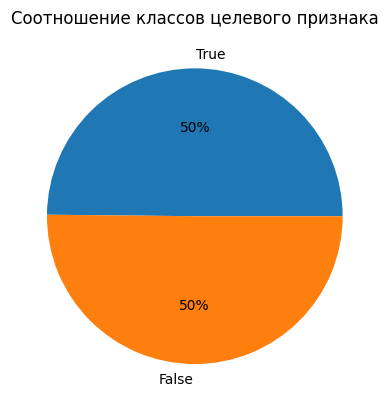

In [28]:
sizes = [df['target'].value_counts()[1], df['target'].value_counts()[0]]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=['True', 'False'], autopct='%1.0f%%')
plt.title('Соотношение классов целевого признака', size=12)
plt.show()

### Выводы и наблюдения
- созданы дополнительные признаки:
  - `days_between_client_purchases`
  - `days_between_cart_purchases`
- удалена дата из данных
- объединены `user_id` и `cart` в признак `id`
- произведена группировка по `id` с агрегациями:
  - `is_holiday` - суммирование
  - `days_between_client_purchases` и `days_between_cart_purchases` - среднее
  - `id` подсчёт количества вхождений
- добавлен целевой признак `target`:
  - '0' - не было повторных покупок
  - '1' - повторные покупки были
- изучено соотношение классов целевого призннака: 50/50

## Подготовка данных

In [29]:
def prepare_for_training(dataset):
    y = dataset['target']
    X = dataset.drop(['target'], axis=1)

    # Разделение данных на выборки
    X_train, X_valid, y_train, y_valid = (train_test_split(X,
                                                           y,
                                                           test_size=0.2,
                                                           random_state=RANDOM_STATE,
                                                           stratify=y)
                                         )

    # Приведение данных к единому масштабу
    scaler = StandardScaler()
    X_train_scl = (pd.DataFrame(scaler.fit_transform(X_train),
                                columns=X_train.columns,
                                index=X_train.index)
                  )
            
    X_valid_scl = (pd.DataFrame(scaler.transform(X_valid),
                                columns=X_valid.columns,
                                index=X_valid.index)
                  )
        
    print(X_train_scl.shape, X_valid_scl.shape, y_train.shape, y_valid.shape)

    return X_train_scl, X_valid_scl, y_train, y_valid

In [30]:
X_train_scl, X_valid_scl, y_train, y_valid = prepare_for_training(df)

(894080, 4) (223520, 4) (894080,) (223520,)


### Выводы и заключения
- выделен целевой признак
- произведено разделение на обучающую и валидационную выборки
- произведено масштабирование данных

## Обучение моделей

### Baseline

In [31]:
lr_st = LogisticRegression(class_weight='balanced', C=1.0, penalty='l2')
lr_st.fit(X_train_scl.drop('id_count_purchases', axis=1), y_train)

LogisticRegression(class_weight='balanced')

#### Проведение кросс-валидации

In [32]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_res = cross_validate(
    lr_st,
    X_train_scl.drop('id_count_purchases', axis=1),
    y_train,
    cv=cv_strategy,
    n_jobs=-1,
    scoring=['f1', 'roc_auc']
)
pd.DataFrame(cv_res)

,fit_time,score_time,test_f1,test_roc_auc
0,1.383351,0.246492,0.707808,0.758049
1,1.319523,0.235911,0.710433,0.760652
2,1.402844,0.322882,0.707014,0.757974
3,1.153216,0.231438,0.707492,0.758274
4,1.292813,0.224806,0.706891,0.756976


### Выводы и наблюдения
- произведено обучение модели логистической регрессии
- произведена кросс-валидация обученной модели

## Проверка лучшей модели на отложенной выборке

In [33]:
lr_st_pred = lr_st.predict(X_valid_scl.drop('id_count_purchases', axis=1))
lr_st_pred_f1 = f1_score(y_valid, lr_st_pred)
print(f'F1 на отложенной выборке: {lr_st_pred_f1}')

F1 на отложенной выборке: 0.7081600591442566


### Выводы и наблюдения
- проверка модели на тестовой выборке показывает хорошие результаты по выбранной метрике

## Предсказания для отправки

In [34]:
sub_df = pd.concat([X_train_scl, X_valid_scl], axis=0)
sub_df['target'] = lr_st.predict(sub_df.drop('id_count_purchases', axis=1))
sub_df = sub_df.iloc[:, -1]
sub_df = sub_df.to_frame().reset_index()
sub_df.head()

,id,target
0,10864;19,1
1,10122;106,0
2,5751;84,0
3,829;439,1
4,7189;442,0


In [35]:
sample_sub.drop('target', axis=1, inplace=True)
merged_df = (sample_sub
             .merge(sub_df,
                    on='id',
                    how='left')
            )

In [36]:
merged_df.to_csv('submission.csv', index=False)
print('submission.csv сохранён')

submission.csv сохранён


In [37]:


#     pipeline = Pipeline(
#         [
#             ('preprocessor', preprocessor),
#             ('model', model)
#         ]
#     )
#     pipeline.fit(data.drop(params['target_col'], axis=1), data[params['target_col']])

# Решение через временные ряды

## Проверка наличия сезонности

Установка даты индексом

In [38]:
# df_w.set_index('order_completed_at', inplace=True)
# df_w.sort_index(inplace=True)

In [39]:
# df_s = df_w.copy()
# df_s.set_index('order_completed_at', inplace=True)
# df_s.sort_index(inplace=True)

In [40]:
# '''разложение на тренд, сезонность и остатки за год'''

# decomposed_units_year = seasonal_decompose(df_s['target'], period=365)

# plt.figure(figsize=(10,6))
# plt.suptitle('Decomposition Analysis of Annual Data', fontsize=12)
# plt.subplot(311)
# decomposed_units_year.trend.plot(ax=plt.gca())
# plt.title('Trend')
# plt.subplot(312)
# decomposed_units_year.seasonal.plot(ax=plt.gca())
# plt.title('Seasonality')
# plt.subplot(313)
# decomposed_units_year.resid.plot(ax=plt.gca())
# plt.title('Residuals')
# plt.tight_layout()

# '''разложение на тренд, сезонность и остатки за две недели'''

# decomposed_units_month = seasonal_decompose(df_s['target']['2019-06-24':'2019-07-24'], period=1)

# plt.figure(figsize=(10,6))
# plt.suptitle('Decomposition Analysis of Monthly Data (June 24, 2019 - July 24, 2019)', fontsize=12)
# plt.subplot(311)
# decomposed_units_month.trend.plot(ax=plt.gca())
# plt.title('Trend')
# plt.subplot(312)
# decomposed_units_month.seasonal.plot(ax=plt.gca())
# plt.title('Seasonality')
# plt.subplot(313)
# decomposed_units_month.resid.plot(ax=plt.gca())
# plt.title('Residuals')
# plt.tight_layout()

### Выводы и наблюдения
- дата установлена в качестве индекса;
- сезонности не обнаружено;
- общего тренда также нет

## Подготовка к обучению

Разделение на `train` и `test`

In [41]:
# df_w.info()

In [42]:
# y = df_w['target']
# X = df_w.drop(['target'], axis=1)

# X_train = X[X.index < (X.index.max() - pd.DateOffset(days=PRED))]
# X_test = X[X.index >= (X.index.max() - pd.DateOffset(days=PRED))]
# y_train = y[:X_train.shape[0]]
# y_test = y[X_train.shape[0]:]
# X_train.shape, X_test.shape, y_train.shape, y_test.shape
# # ((1431604, 3), (1691460, 3), (1431604,), (1691460,)) PRED = 120
# # ((2677986, 3), (445078, 3), (2677986,), (445078,)) PRED = 30

Масштабирование данных

In [43]:
# scaler = StandardScaler()
# X_train_scl = (pd.DataFrame(scaler.fit_transform(X_train.drop(['id'], axis=1)),
#                             columns=X_train.drop(['id'], axis=1).columns,
#                             index=X_train.drop(['id'], axis=1).index))
# X_train_scl = pd.concat([X_train_scl, X_train[['id']]], axis=1)
# X_test_scl = (pd.DataFrame(scaler.transform(X_test.drop(['id'], axis=1)),
#                            columns=X_test.drop(['id'], axis=1).columns,
#                            index=X_test.drop(['id'], axis=1).index))
# X_test_scl = pd.concat([X_test_scl, X_test[['id']]], axis=1)

# X_train_scl.shape, X_test_scl.shape

## Обучение модели

Baseline - LogisticRegression
<br>Предсказания на обучающей выборке

In [44]:
# baseline = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')
# baseline.fit(X_train_scl.drop(['id'], axis=1), y_train)
# baseline_pred = baseline.predict(X_train_scl.drop(['id'], axis=1))
# baseline_f1 = f1_score(y_train, baseline_pred)
# baseline_f1

Предсказания на тестовой выборке

In [45]:
# baseline_test_pred = baseline.predict(X_test_scl.drop(['id'], axis=1))
# baseline_test_f1 = f1_score(y_test, baseline_test_pred)
# baseline_test_f1

In [46]:
# X_test_pr = X_test_scl.copy()
# X_test_pr['baseline'] = baseline_test_pred
# X_test_pr['target'] = y_test.values
# X_test_pr.tail()
# # X_test_pr['predictions'].sum(), X_test_pr['target'].sum()

Случайный лес
<br>Предсказания на обучающей выборке

In [47]:
# rfc = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')
# rfc.fit(X_train_scl.drop(['id'], axis=1), y_train)
# rfc_pred = rfc.predict(X_train_scl.drop(['id'], axis=1))
# rfc_f1 = f1_score(y_train, rfc_pred)
# rfc_f1

Предсказания на тестовой выборке

In [48]:
# rfc_test_pred = rfc.predict(X_test_scl.drop(['id'], axis=1))
# rfc_test_f1 = f1_score(y_test, rfc_test_pred)
# rfc_test_f1

In [49]:
# X_test_pr['rfc'] = rfc_test_pred
# display(X_test_pr.tail())
# X_test_pr['baseline'].sum(), X_test_pr['target'].sum(), X_test_pr['rfc'].sum()

## Обучение на полном наборе данных и получение предсказаний покупок

Добавление рандомной даты

In [50]:
# sample_sub['date'] = pd.to_datetime('2020-03-31')
# sample_sub.drop(['target'], axis=1, inplace=True)

Добавление признака `is_holiday`

In [51]:
# sample_sub['is_holiday'] = sample_sub['date'].isin(holidays['date']).astype('int8')

Удаление всех записей, кроме самых последних `id`

In [52]:
# df_unique_last = X.drop_duplicates(subset='id', keep='last')
# sample_sub = sample_sub.merge(df_unique_last[['id', 'client_cum_sum_120']], how='left', on='id')
# sample_sub.set_index('date', inplace=True)
# sample_sub.sort_index(inplace=True)

Масштабирование данных

In [53]:
# X_scl = (pd.DataFrame(scaler.fit_transform(X.drop(['id'], axis=1)),
#                       columns=X.drop(['id'], axis=1).columns,
#                       index=X.drop(['id'], axis=1).index))
# X_scl = pd.concat([X_scl, X['id']], axis=1)
# X_sub_scl = (pd.DataFrame(scaler.transform(sample_sub[['client_cum_sum_120', 'is_holiday']]),
#                           columns=sample_sub[['client_cum_sum_120', 'is_holiday']].columns,
#                           index=sample_sub[['client_cum_sum_120', 'is_holiday']].index))
# X_sub_scl = pd.concat([X_sub_scl, sample_sub['id']], axis=1)

# X_scl.shape, X_sub_scl.shape

Обучение модели

In [54]:
# rfc = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')
# rfc.fit(X_scl.drop(['id'], axis=1), y)
# rfc_pred_big = rfc.predict(X_scl.drop(['id'], axis=1))
# rfc_big_f1 = f1_score(y, rfc_pred_big)
# rfc_big_f1

Предсказания для отправки

In [55]:
# X_sub_scl

In [56]:
# rfc_sub_pred = rfc.predict(X_sub_scl.drop(['id'], axis=1))
# submission = X_sub_scl.copy()
# submission['target'] = rfc_sub_pred

In [57]:
# submission.drop(['client_cum_sum_120', 'is_holiday'], axis=1, inplace=True)
# submission.reset_index(drop=True, inplace=True)
# submission.head()

In [58]:
# submission.to_csv('submission.csv', index=False)
# print('submission.csv сохранён')